# Assignment for Week 6 - K-Means and Hierarchical Clustering

Collect data from twitter using your choice of hashtag (at least 1000 tweets). 
To gather your Twitter data, I would recommend using the python library tweepy.<br>
Note: Reddit data can be used instead of Twitter data for this assignment.

- You will use both K-Means (**See section *3 K-Means Clustering***) and
  HCA (**See section *4 Hierarchical Cluster Analysis***) to cluster the
  collected data
- Draw a dendrogram (**See section *4.B HCA Dendrogram***)
- Identify number of optimum clusters, and justify how do you pick number of
  clusters (**See section *3.B K-Means Silhouette***)
- List the top 10 most frequent words (**See section *2.C Topic Metrics***)
- Visualize using wordclouds (**See section *2.B Topic Exploration***)
- Summarize your findings

# 1 Setup

## 1.A Python / Jupyter Setup

In addition to the normal setup, we also create some user defined functions
(UDF) to
* facilitate working with Gensim Doc2Vec
* automate collection of K-Means metrics for various value of `k`
* automate the display of metrics
* automate the display of word clouds


In [1]:
import gensim
import json
import logging
import matplotlib.pyplot as plt
import nltk.corpus
import nltk.cluster
import nltk.data
import nltk.help
import nltk.stem
import nltk.tag
import nltk.tokenize
import numpy as np
import os
import pandas as pd
import scipy.cluster.hierarchy
import sklearn.cluster
import sklearn.decomposition
import sklearn.feature_extraction.text
import sklearn.manifold
import sklearn.metrics
import sklearn.pipeline
import tweets
import wordcloud

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.options.display.max_rows = 100

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-7s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
for logger in ['matplotlib', 'tweepy.api', 'requests_oauthlib', 'oauthlib', 'urllib3', 'gensim']:
    logging.getLogger(logger).setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

RANDOM_SEED     = 42
MAX_CLUSTERS    = 30

def create_vectorizer(df, column_name='transformed_text'):
    ''' This functions creates a Gensim Doc2Vec vectorizer which generates
        vectors describing phras semantics such that similar topics have
        vectors with similar cosine values.
    '''

    def create_gensim_documents(df):
        ''' This (hidden) function creates a Gensim TaggedDocument containing
            all words in a given Tweet.  For this exercise (unsupervised
            clustering), we do not apply any tags.
        '''
        docs = []

        for _, row in df.iterrows():
            td = gensim.models.doc2vec.TaggedDocument(row[column_name].split(), [])

            # if len(docs) <= 5:
            #     LOGGER.debug(f'Gensim Tagged Document: {td}')

            docs.append(td)
        return docs

    # Initialize the vectorizer
    vectorizer  = gensim.models.doc2vec.Doc2Vec(min_count=2,
                                                epochs=30,
                                                seed=RANDOM_SEED)

    # Convert all Tweets into Gensim documents, build the vocabulary, then
    # train the vectorizer
    sentences   = df.pipe(create_gensim_documents)
    vectorizer.build_vocab(sentences)
    vectorizer.train(sentences,
                     epochs=30,
                     total_examples=vectorizer.corpus_count)

    return vectorizer

def kmeans_metrics(df, max_k=MAX_CLUSTERS, column_name='transformed_text'):
    LOGGER.debug(f'Starting K-Means analysis ...')

    vectorizer = create_vectorizer(df, column_name)

    def infer_vector(row, column_index, vectorizer):
        return vectorizer.infer_vector(row.get(column_index).split())

    X = df.apply(infer_vector,
                 axis='columns',
                 result_type='expand',
                 args=(df.columns.get_loc(column_name), vectorizer, ))

    metrics_df = pd.DataFrame()

    for k in range(2, max_k + 1):
        km_model    = sklearn.cluster.KMeans(n_clusters=k, random_state=RANDOM_SEED)

        normed_vectors = vectorizer.wv.get_normed_vectors()
        km_model.fit(normed_vectors)

        km_predictions  = km_model.predict(X)
        km_wcss         = -km_model.score(X)
        km_silhouette   = sklearn.metrics.silhouette_score(X, km_predictions)

        LOGGER.debug(f'K-means with k={k:3d} ... wcss: {km_wcss:.3f}, silhouette: {km_silhouette:.3f}')

        metrics_df = pd.concat([metrics_df,
                                pd.DataFrame([{'k': k, 'km_wcss': km_wcss, 'km_silhouette': km_silhouette }])],
                               ignore_index=True)

    return (metrics_df, vectorizer)

def plot_k_v_silhouette(df, metric_column='silhouette', title='K vs Silhouette'):
    # Matplotlib annotation code courtesy of StackOverflow.com (2017)
    _, ax = plt.subplots()

    x       = df['k']
    y       = df[metric_column]
    x_max   = x[np.argmax(y)]
    y_max   = y.max()

    text = f'k={x_max}, {metric_column}={y_max:.3f}'
    kw  = dict(xycoords     = 'data',
            textcoords   = "axes fraction",
            arrowprops   = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60"),
            bbox         = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72),
            ha           = "right",
            va           = "top")
    ax.annotate(text, xy=(x_max, y_max), xytext=(0.94, 0.96), **kw)

    ax.set_title(title)
    ax.set_xlim(0, x.max() * 1.3)
    ax.set_ylim(0, y_max * 1.3)
    plt.scatter(x, y)

def plot_wordclouds(df, labels=None, label_column='topic', text_column='transformed_text'):
    labels = labels or df[label_column].unique()
    for lbl in labels:
        rows        = ' '.join(df[df[label_column] == lbl][text_column])
        words       = rows.split()
        word_freq   = pd.Series(words).value_counts().to_dict()
        wc          = wordcloud.WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(word_freq)

        LOGGER.info(f'Word cloud for label "{lbl}"')

        plt.figure(figsize=(10, 10))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.B Collect Data (Tweets)

One of the problems with collecting data via the Twitter API is the rate
limiting that occurs.  For that reason, the Tweets for each successfully
retrieved topic are saved to a file and can be skipped on subsequent attempts.
This allows Tweets to be collected over a period of time compliant with the
rate limit and prevents the rate limit from being consumed by retrieving data
which has already been retrieved.



In [2]:
api = tweets.TwitterApi.from_credentials('./twitter-secrets.yaml')

topics = ['nascar', 'artificial intelligence', 'gators']

for t in topics:
    hashtag_path = f'data/{t.replace("#", "").replace(" ", "-").lower()}-tweets.json'

    if os.path.exists(hashtag_path):
        LOGGER.debug(f'Already retrieved tweets for "{t}"')
    else:
        try:
            LOGGER.debug(f'Retrieving tweets for "{t}" ...')
            hashtag_tweets  = api.hashtag_tweets(t, limit=1500, ignore_retweets=True)

            with open(hashtag_path, 'w') as file:
                for ht in hashtag_tweets:
                    file.write(json.dumps(ht, separators=(',', ':')))
                    file.write('\n')
        except Exception as ex:
            LOGGER.warning(f'{ex}')



2022-02-21 02:17:11 - DEBUG   -   MSDS-680 - Already retrieved tweets for "nascar"
2022-02-21 02:17:11 - DEBUG   -   MSDS-680 - Already retrieved tweets for "artificial intelligence"
2022-02-21 02:17:11 - DEBUG   -   MSDS-680 - Already retrieved tweets for "gators"


## 1.C Load Data (Tweets)

As previously mentioned, downloaded Tweets are stored to file.  Therefore, the
actual DataFrame is created from the stored files rather than directly via the
API.  The file format is a collection of JSON objects originally retrieved from
the Twitter API.

In [3]:
tweet_df = pd.DataFrame()

for root, dirs, files in os.walk('data'):
    for f in files:
        if f.endswith('-tweets.json'):
            topic   = f.replace('-tweets.json', '')
            path    = os.path.join(root, f)

            with open(path) as tweet_file:
                LOGGER.debug(f'Loading tweets for "{topic}"')
                topic_tweets = [json.loads(tweet) for tweet in tweet_file]

                topic_df = pd.DataFrame(topic_tweets)
                topic_df['topic'] = topic

                tweet_df = pd.concat([tweet_df, topic_df])

LOGGER.info(f'Working with {len(tweet_df["topic"].unique())} topics')
for key, value in tweet_df['topic'].value_counts().iteritems():
    LOGGER.info(f'Topic {key:.<30} {value} tweets')
tweet_df.head(5)

2022-02-21 02:17:11 - DEBUG   -   MSDS-680 - Loading tweets for "artificial-intelligence"
2022-02-21 02:17:12 - DEBUG   -   MSDS-680 - Loading tweets for "gators"
2022-02-21 02:17:12 - DEBUG   -   MSDS-680 - Loading tweets for "nascar"
2022-02-21 02:17:12 - INFO    -   MSDS-680 - Working with 3 topics
2022-02-21 02:17:12 - INFO    -   MSDS-680 - Topic artificial-intelligence....... 1500 tweets
2022-02-21 02:17:12 - INFO    -   MSDS-680 - Topic gators........................ 1500 tweets
2022-02-21 02:17:12 - INFO    -   MSDS-680 - Topic nascar........................ 1500 tweets


,created_at,id,id_str,text,truncated,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status,topic
0,Sun Feb 20 00:20:23 +0000 2022,1495191566960533505,1495191566960533505,@DailyReySky @NRey005 tomorrow is the big game...,True,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,1.423294e+18,...,0,1,False,False,False,en,NaN,NaN,NaN,artificial-intelligence
1,Sun Feb 20 00:18:46 +0000 2022,1495191158871539719,1495191158871539719,Tammy C. Woolley: Artificial Intelligence in H...,True,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://Neurons.AI"" rel=""nofollow"">Neu...",NaN,None,NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,artificial-intelligence
2,Sun Feb 20 00:18:45 +0000 2022,1495191155612557312,1495191155612557312,#transhumanism. The visions of a sociopath who...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,...,4,8,False,False,False,en,NaN,NaN,NaN,artificial-intelligence
3,Sun Feb 20 00:18:44 +0000 2022,1495191152437329920,1495191152437329920,'Our goal: to deliver scientific outcomes info...,True,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,...,1,1,False,False,False,en,NaN,NaN,NaN,artificial-intelligence
4,Sun Feb 20 00:18:29 +0000 2022,1495191090315640832,1495191090315640832,Time to get off the ‘career track’ | TheHill -...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://Neurons.AI"" rel=""nofollow"">Neu...",NaN,None,NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,artificial-intelligence


# 2 EDA and Text Preprocessing

## 2.A Text Preprocessing

Below, we perform text pre-processing similar to Week 3, with a few differences:
* Utilize `nltk.tokenize.TweetTokenizer` (vice `nltk.tokenize.word_tokenize`)
  which preserves hashtags (`#`) and user mentions (`@`) as opposed to simply
  removing them
* Having preserved hashtags, we remove the hashtag word which could be
  considered a proxy for the topic/label.

In [4]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
STOP_WORDS.add('http')
STOP_WORDS.add('https')
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

def transform_text(content, verbose=False):
    if verbose: LOGGER.debug(f'Before: {content}')

    tokenizer = nltk.tokenize.TweetTokenizer()
    words = tokenizer.tokenize(content)

    # Remove hashtags
    words = [w for w in words if not w.startswith('#')]

    words = [w for w in words if w.isalpha()]
    words = [w.lower() for w in words]
    words = [w for w in words if not w in STOP_WORDS]
    words = [wordnet_lemmatizer.lemmatize(w) for w in words]

    content = ' '.join(words)

    if verbose: LOGGER.debug(f'After:  {content}')
    return content

_ = tweet_df.head()['text'].apply(transform_text, verbose=True)

2022-02-21 02:17:12 - DEBUG   -   MSDS-680 - Before: @DailyReySky @NRey005 tomorrow is the big game the all star game King James vs KD please use the force to have Jame… https://t.co/uOACuQPvyv
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - After:  tomorrow big game star game king james v kd please use force jame
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - Before: Tammy C. Woolley: Artificial Intelligence in HR: A blessing and a curse | | https://t.co/NvVzBZl9Qz - Artificial… https://t.co/xQmWdAMrWs
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - After:  tammy c woolley artificial intelligence hr blessing curse artificial
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - Before: #transhumanism. The visions of a sociopath who wants to subject us all to artificial intelligence. https://t.co/1IwDoJN3Kl
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - After:  vision sociopath want subject u artificial intelligence
2022-02-21 02:17:14 - DEBUG   -   MSDS-680 - Before: 'Our goal: to deliver scientific out

## 2.B Topic Exploration

Below, we create a word cloud for each Tweet topic in order to perform a
sanity check on the preprocessing.

2022-02-21 02:17:16 - INFO    -   MSDS-680 - Word cloud for label "artificial-intelligence"


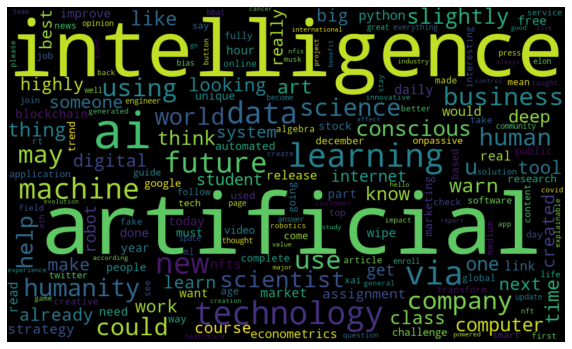

2022-02-21 02:17:17 - INFO    -   MSDS-680 - Word cloud for label "gators"


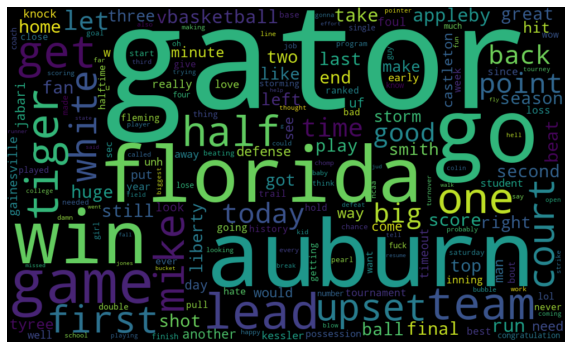

2022-02-21 02:17:18 - INFO    -   MSDS-680 - Word cloud for label "nascar"


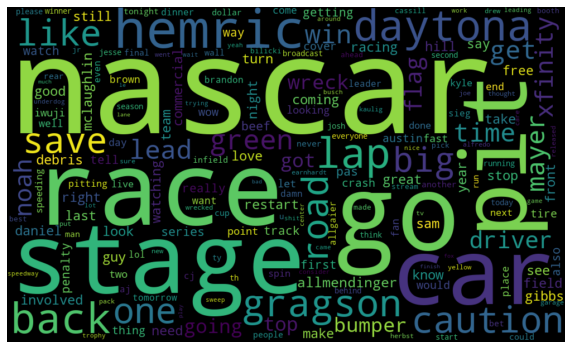

In [5]:
tweet_df['transformed_text'] = tweet_df['text'].apply(transform_text)

def count_text(content):
    return len(content.split())

tweet_df['word_count'] = tweet_df['transformed_text'].apply(count_text)

plot_wordclouds(tweet_df)


## 2.C Topic Metrics

One concern with Tweets is their terseness.  While this is part of the appeal
of Twitter, if often yields results that, after preprocessing, contain only
one or two words.  For this exercise, we arbitrarily set a limit of at least
5 words for a Tweet to be included in the study.

In [6]:
tweet_df = tweet_df[tweet_df.word_count > 4]
tweet_df.groupby(['topic']).aggregate({ 'word_count': ['min', 'max', 'mean']})


word_count              
                               min max      mean
topic                                           
artificial-intelligence          5  22  8.884728
gators                           5  16  8.781220
nascar                           5  22  8.345416

The top 10 most frequent words for each category are printed below:

In [7]:
for topic in tweet_df['topic'].unique():
    topic_df = tweet_df[tweet_df['topic'] == topic]

    counter             = sklearn.feature_extraction.text.CountVectorizer()
    count_matrix        = counter.fit_transform(topic_df['transformed_text'])
    vocabulary_words    = counter.get_feature_names_out()

    term_counts     = count_matrix.sum(axis=0)
    term_counts     = term_counts.A1
    sorted_indices  = list(reversed(np.argsort(term_counts)))

    LOGGER.info(f'Topic {topic}:')

    for index in sorted_indices[:10]:
        word        = vocabulary_words[index]
        count       = term_counts[index]

        LOGGER.info(f'     "{word}" appears {count} times')


2022-02-21 02:17:19 - INFO    -   MSDS-680 - Topic artificial-intelligence:
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "artificial" appears 930 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "intelligence" appears 887 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "ai" appears 255 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "learning" appears 78 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "technology" appears 76 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "via" appears 74 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "data" appears 68 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "new" appears 67 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "machine" appears 60 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "future" appears 59 times
2022-02-21 02:17:19 - INFO    -   MSDS-680 - Topic gators:
2022-02-21 02:17:19 - INFO    -   MSDS-680 -      "gator" appears 708 times
2022-02-21 02:17:19 -

# 3 K-Means Clustering

K-Means is a centroid-based clustering model which allocates every data point
to the nearest cluster, while keeping the errors as small as possible
(Week 6 Lecture).

## 3.A K-Means Using Range of `k`
Below,  we perform K-Means for a range of `k` values and collect metrics for
each value of `k`

In [8]:
metrics_df, vectorizer = kmeans_metrics(tweet_df)


2022-02-21 02:17:19 - DEBUG   -   MSDS-680 - Starting K-Means analysis ...
2022-02-21 02:17:40 - DEBUG   -   MSDS-680 - K-means with k=  2 ... wcss: 1534.938, silhouette: 0.115
2022-02-21 02:17:43 - DEBUG   -   MSDS-680 - K-means with k=  3 ... wcss: 1441.915, silhouette: 0.120
2022-02-21 02:17:45 - DEBUG   -   MSDS-680 - K-means with k=  4 ... wcss: 1347.183, silhouette: 0.078
2022-02-21 02:17:47 - DEBUG   -   MSDS-680 - K-means with k=  5 ... wcss: 1326.248, silhouette: 0.048
2022-02-21 02:17:48 - DEBUG   -   MSDS-680 - K-means with k=  6 ... wcss: 1271.099, silhouette: 0.039
2022-02-21 02:17:50 - DEBUG   -   MSDS-680 - K-means with k=  7 ... wcss: 1233.581, silhouette: 0.041
2022-02-21 02:17:51 - DEBUG   -   MSDS-680 - K-means with k=  8 ... wcss: 1213.064, silhouette: 0.031
2022-02-21 02:17:53 - DEBUG   -   MSDS-680 - K-means with k=  9 ... wcss: 1205.323, silhouette: 0.023
2022-02-21 02:17:54 - DEBUG   -   MSDS-680 - K-means with k= 10 ... wcss: 1177.910, silhouette: 0.024
2022-02

## 3.B K-Means Silhouette

Below, we plot `k` vs the silhouette score.

Generally speaking, one is looking for a (dramatic) peak silhouette value at
the optimum `k`.

Due to the high number of dimensions and the variety of intra-topic vocabulary,
silhouette is not necessarily ideal for this use-case, but sufficient for this
experiment.

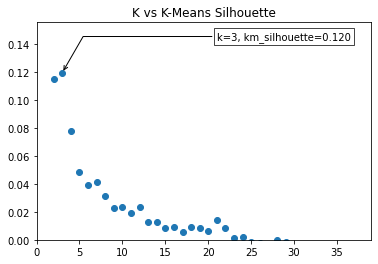

In [9]:
plot_k_v_silhouette(metrics_df, metric_column='km_silhouette', title='K vs K-Means Silhouette')


## 3.C K-Means WCSS

Below, we plot `k` vs the within-cluster sum of squares (WCSS).

Generally speaking, one is looking for a noticeable "elbow" in the curve in
order to determing the optimal `k`.

As can be seen below, there isn't a noticeable elbow utilizing WCSS.  Instead,
we see a gradual curve.

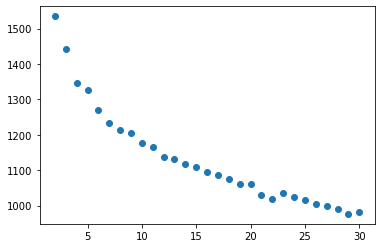

In [10]:
plt.scatter(metrics_df['k'], metrics_df['km_wcss'])

## 3.D K-Means Delta-WCSS

Below, we plot `k` vs the step-wise change of WCSS, which illustrates the
dramatic change between `k=3` and `k=4`


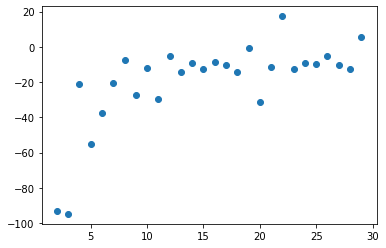

In [11]:
plt.scatter(metrics_df['k'][:-1], np.diff(metrics_df['km_wcss']))

# 4 Hierarchical Cluster Analysis

Hierarchical Cluster Analysis (HCA) is a clustering algorithm which recursively
merges pair of clusters of sample data by repeatedly (Week 6 Lecture):

1. identify the two clusters that are closest together
2. merge the two most similar clusters

## 4.A HCA Using Range of `k`

Below,  we perform HCA for a range of `k` values

In [12]:
for k in range(2, MAX_CLUSTERS + 1):
    hca_model = sklearn.cluster.AgglomerativeClustering(n_clusters=k,
                                                        affinity='cosine',
                                                        linkage='average')


    normed_vectors = vectorizer.wv.get_normed_vectors()
    hca_predictions = hca_model.fit_predict(normed_vectors)

    hca_silhouette   = sklearn.metrics.silhouette_score(normed_vectors, hca_predictions)

    LOGGER.debug(f'HCA with k={k:3d} ... silhouette: {hca_silhouette:.3f}')


2022-02-21 02:18:52 - DEBUG   -   MSDS-680 - HCA with k=  2 ... silhouette: 0.504
2022-02-21 02:18:52 - DEBUG   -   MSDS-680 - HCA with k=  3 ... silhouette: 0.432
2022-02-21 02:18:53 - DEBUG   -   MSDS-680 - HCA with k=  4 ... silhouette: 0.423
2022-02-21 02:18:53 - DEBUG   -   MSDS-680 - HCA with k=  5 ... silhouette: 0.381
2022-02-21 02:18:54 - DEBUG   -   MSDS-680 - HCA with k=  6 ... silhouette: 0.355
2022-02-21 02:18:54 - DEBUG   -   MSDS-680 - HCA with k=  7 ... silhouette: 0.300
2022-02-21 02:18:55 - DEBUG   -   MSDS-680 - HCA with k=  8 ... silhouette: 0.281
2022-02-21 02:18:55 - DEBUG   -   MSDS-680 - HCA with k=  9 ... silhouette: 0.269
2022-02-21 02:18:56 - DEBUG   -   MSDS-680 - HCA with k= 10 ... silhouette: 0.237
2022-02-21 02:18:56 - DEBUG   -   MSDS-680 - HCA with k= 11 ... silhouette: 0.227
2022-02-21 02:18:57 - DEBUG   -   MSDS-680 - HCA with k= 12 ... silhouette: 0.249
2022-02-21 02:18:58 - DEBUG   -   MSDS-680 - HCA with k= 13 ... silhouette: 0.245
2022-02-21 02:18

## 4.B HCA Dendrogram

Per the lecture:

    We can use a dendrogram to visualize the history of groupings and figure out
    the optimal number of clusters. Determine the largest vertical distance that
    doesn’t intersect any of the other clusters Draw a horizontal line at both
    extremities The optimal number of clusters is equal to the number of
    vertical lines going through the horizontal line.

Unfortunately, as can be seen below, a dendrogram for a large number of samples
can be difficult to read.

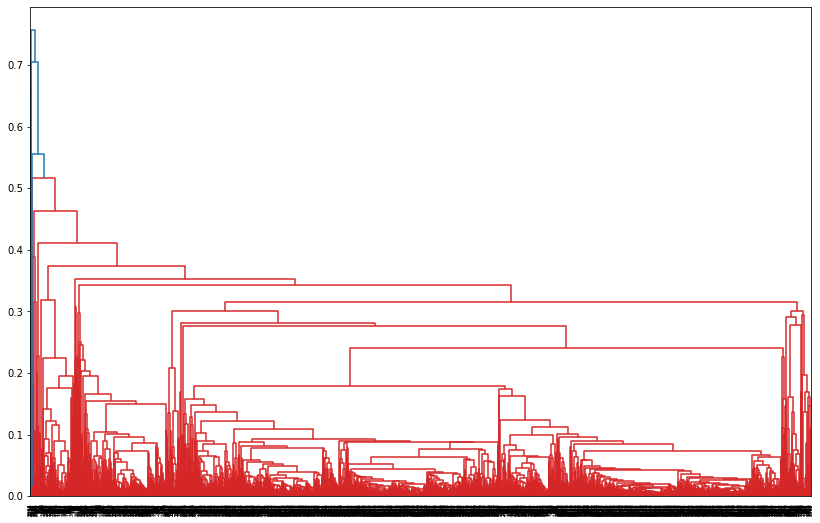

In [13]:
linkage = scipy.cluster.hierarchy.linkage(normed_vectors,
                                          method='average',
                                          metric='cosine')

plt.figure(figsize=(14, 9))

_ = scipy.cluster.hierarchy.dendrogram(linkage)


# 5 Summary

I found this execercise to be exceptionally difficult.  The Tweets did not
seem to cluster together as expected.  I still applied the K-Means and HCA
models as instructed, as well as exercising k-optimization methods such as
the elbow method, silhouette score, etc.

Originally, I used a bag-of-words approach with TfidfVectorizer but it
yielded poor results, even when adding dimensionality reduction with t-SNE.

As can be seen above, I switched to Gensim's Doc2Vec which relies on word/phrase
semantics.  When using Doc2Vec, it seemed appropriate to use `cosine` distance
measurements for HCA. Even so, the Doc2Vec approach also yielded inconsistent
results.  There is also a better than even chance that I'm using Doc2Vec
incorrectly.  **See *Appendix - Simpsons Experiment***

So, the NLP portion of this project needs **a lot** more work.

In additional to improving the NLP processing itself, another improvement
would be visualizing the topics themselves and adjusting expectations
accordingly.  In other words, it might be incorrect to expect all Tweets on
artificial intelligence to cluster together -- more likely, the Tweets cluster
under "sub-topics" within artificial intelligence.  Without a way to visualize
and understand the clustering, it's difficult to ensure the optimum clusters
truly are being selected.

# Appendix - Simpsons Experiment

As mentioned above, I experienced quite a few issues with the NLP portion of
this exercise.  I did experiment with the alternative data set offered for this
week's assignment, but stubbornly continued coming back to NLP.

As I experimented with Gensim, I referred to *Fun in text mining with Simpsons*
(Kaggle.com, 2021) to verify step-by-step that I was utilizing Doc2Vec
appropriately.

I've preserved the work below.

In [14]:
simpsons_df = pd.read_csv('data/simpsons_script_lines.csv', low_memory=False)
LOGGER.info(f'simpsons_df.shape ==> {simpsons_df.shape[0]} rows x {simpsons_df.shape[1]} cols')
simpsons_df = simpsons_df[simpsons_df['normalized_text'].notna()]
simpsons_df = simpsons_df[simpsons_df['raw_character_text'].notna()]
simpsons_df.head()


2022-02-21 02:19:56 - INFO    -   MSDS-680 - simpsons_df.shape ==> 158271 rows x 13 cols


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33


In [15]:
logged_characters = 0
for k, v in simpsons_df['raw_character_text'].value_counts().iteritems():
    LOGGER.debug(f'Character "{k}" has {v} lines')
    logged_characters = logged_characters + 1
    if logged_characters >= 5:
        break

# This data set is quite large... focus on two "topics"
characters = ['Homer Simpson', 'Bart Simpson']
simpsons_df = simpsons_df[simpsons_df['raw_character_text'].isin(characters)]

# and further down-sample
# simpsons_df = simpsons_df.sample(frac=.33, random_state=RANDOM_SEED)
LOGGER.info(f'Down-sampled simpsons_df.shape ==> {simpsons_df.shape[0]} rows x {simpsons_df.shape[1]} cols')


2022-02-21 02:19:56 - DEBUG   -   MSDS-680 - Character "Homer Simpson" has 27909 lines
2022-02-21 02:19:56 - DEBUG   -   MSDS-680 - Character "Marge Simpson" has 13191 lines
2022-02-21 02:19:56 - DEBUG   -   MSDS-680 - Character "Bart Simpson" has 13011 lines
2022-02-21 02:19:56 - DEBUG   -   MSDS-680 - Character "Lisa Simpson" has 10767 lines
2022-02-21 02:19:56 - DEBUG   -   MSDS-680 - Character "C. Montgomery Burns" has 3086 lines
2022-02-21 02:19:56 - INFO    -   MSDS-680 - Down-sampled simpsons_df.shape ==> 40920 rows x 13 cols


In [16]:
simpsons_vectorizer = create_vectorizer(simpsons_df, 'normalized_text')


Now, we experiment with the power of Gensim ... semantic comparison.

Examining the word association below, 'burns' and 'smithers' seems like a
reasonable association, as does 'lisa' and 'bart'.  However, 'nelson' and
'sailed' does not make sense.

Regarding cosine similarity, one would think the association between 'maggie'
and 'baby' would be much higher.

Finally, excluding 'bart' from the collection with 'jimbo' and 'kearney'
seems correct, but 'bart' should more similar to 'milhouse' than 'nelson'.

In [17]:
# What word most strongly associated with another word:
for word in ['burns', 'smithers', 'marge', 'lisa', 'nelson']:
    similar = simpsons_vectorizer.wv.most_similar(positive=[word])
    similar_word, similar_pct = similar[0]
    LOGGER.debug(f'The word most strongly associated with "{word}": {similar_word} ({similar_pct:.2%})')

# What's the cosine similarity between two words:
for pair in [('maggie', 'baby'), ('beer', 'drink'), ('mayor', 'quimby')]:
    cos_similarity = simpsons_vectorizer.wv.similarity(*pair)
    LOGGER.debug(f'Cosine similarity between "{pair[0]}" and "{pair[1]}" is: {cos_similarity:.3f}')

# Which word is "different" (least similar) to other words:
for triple in [('jimbo', 'kearney', 'bart'), ('bart', 'nelson', 'milhouse')]:
    excluded = simpsons_vectorizer.wv.doesnt_match(triple)
    LOGGER.debug(f'Of the triple {triple}, "{excluded}" doesn\'t belong')


2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - The word most strongly associated with "burns": x (74.97%)
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - The word most strongly associated with "smithers": hutz (84.14%)
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - The word most strongly associated with "marge": but (59.19%)
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - The word most strongly associated with "lisa": bart (54.97%)
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - The word most strongly associated with "nelson": opening (46.00%)
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - Cosine similarity between "maggie" and "baby" is: 0.429
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - Cosine similarity between "beer" and "drink" is: 0.583
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - Cosine similarity between "mayor" and "quimby" is: 0.340
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - Of the triple ('jimbo', 'kearney', 'bart'), "bart" doesn't belong
2022-02-21 02:22:33 - DEBUG   -   MSDS-680 - Of t

In [18]:
def infer_vector(row, column_index, vectorizer):
    return vectorizer.infer_vector(row.get(column_index).split())

# As I understand it, we now have to create semantic vectors for each text
# values to describe them using the same features created by Doc2Vec
#
# This basically becomes our new X (input)
simpsons_X = simpsons_df.apply(infer_vector,
                               axis='columns',
                               result_type='expand',
                               args=(simpsons_df.columns.get_loc('normalized_text'), simpsons_vectorizer, ))

LOGGER.info(f'simpsons_X.shape ==> {simpsons_X.shape[0]} rows x {simpsons_X.shape[1]} cols')

simpsons_k = len(simpsons_df['raw_character_text'].unique())
LOGGER.info(f'Using k={simpsons_k} for Simpsons K-Means clustering')
simpsons_model = sklearn.cluster.KMeans(n_clusters=simpsons_k, random_state=RANDOM_SEED)

simpsons_model.fit(simpsons_vectorizer.wv.get_normed_vectors())

predictions = simpsons_model.predict(simpsons_X)
wcss        = -simpsons_model.score(simpsons_X)
silhouette  = sklearn.metrics.silhouette_score(simpsons_X, predictions)

LOGGER.debug(f'With k={simpsons_k} ... wcss: {wcss:.3f}, silhouette: {silhouette:.3f}')


2022-02-21 02:23:37 - INFO    -   MSDS-680 - simpsons_X.shape ==> 40920 rows x 100 cols
2022-02-21 02:23:37 - INFO    -   MSDS-680 - Using k=2 for Simpsons K-Means clustering
2022-02-21 02:24:06 - DEBUG   -   MSDS-680 - With k=2 ... wcss: 74846.969, silhouette: 0.060


In [19]:

kmeans_metrics(simpsons_df, max_k=5, column_name='normalized_text')


2022-02-21 02:24:06 - DEBUG   -   MSDS-680 - Starting K-Means analysis ...
2022-02-21 02:28:09 - DEBUG   -   MSDS-680 - K-means with k=  2 ... wcss: 74769.352, silhouette: 0.056
2022-02-21 02:28:37 - DEBUG   -   MSDS-680 - K-means with k=  3 ... wcss: 73435.555, silhouette: 0.064
2022-02-21 02:29:05 - DEBUG   -   MSDS-680 - K-means with k=  4 ... wcss: 73293.148, silhouette: 0.060
2022-02-21 02:29:35 - DEBUG   -   MSDS-680 - K-means with k=  5 ... wcss: 73046.711, silhouette: 0.019


(   k       km_wcss  km_silhouette
 0  2  74769.351562       0.055734
 1  3  73435.554688       0.064405
 2  4  73293.148438       0.060106
 3  5  73046.710938       0.018973,
 <gensim.models.doc2vec.Doc2Vec at 0x7f678afe0df0>)

Overall, I did gain familiarity with Gensim Doc2Vec, but (as stated earlier)
much more work is required to verify correct usage.

# References

StackOverflow.com (2017, April).  How to automatically annotate maximum value in pyplot.  Retrieved from https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot

Kaggle.com (2021, May).  Fun in text mining with Simpsons.  Retrieved from https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons

Mysiak, K. (2020, July). Explaining K-Means clustering.  Retrieved from https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6